In [68]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
# from dlnpyutils.utils import bspline, mad
from dlnpyutils import utils as dln

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

# tqdm
from tqdm.notebook import tqdm

In [69]:
import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

# PARSEC

In [70]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

In [71]:
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.5))]

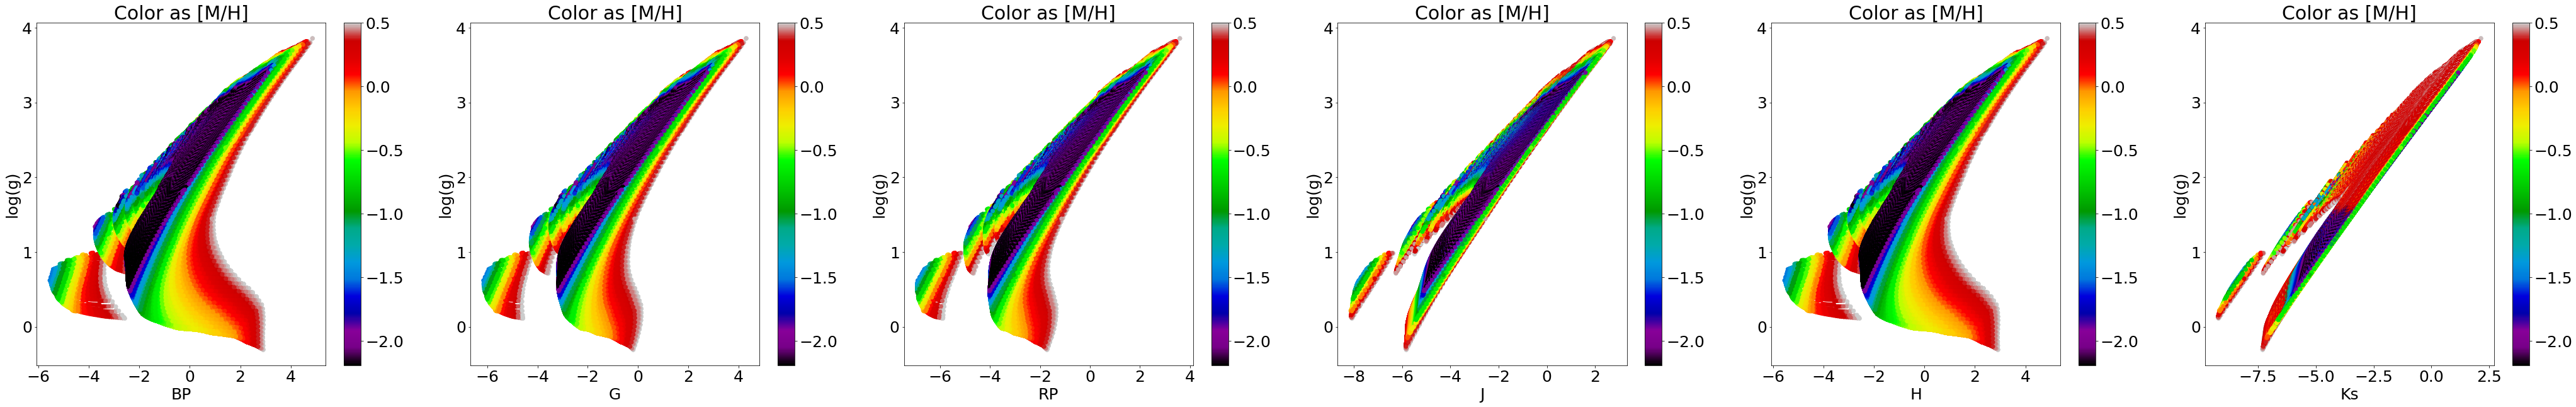

In [72]:
plt.figure(figsize=[72,10])

plt.subplot(161)
plt.scatter(massive['G_BPEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'BP')

plt.subplot(162)
plt.scatter(massive['GEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G')

plt.subplot(163)
plt.scatter(massive['G_RPEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'RP')

plt.subplot(164)
plt.scatter(massive['Jmag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'J')

plt.subplot(165)
plt.scatter(massive['G_BPEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'H')

plt.subplot(166)
plt.scatter(massive['Ksmag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'Ks')

plt.show()

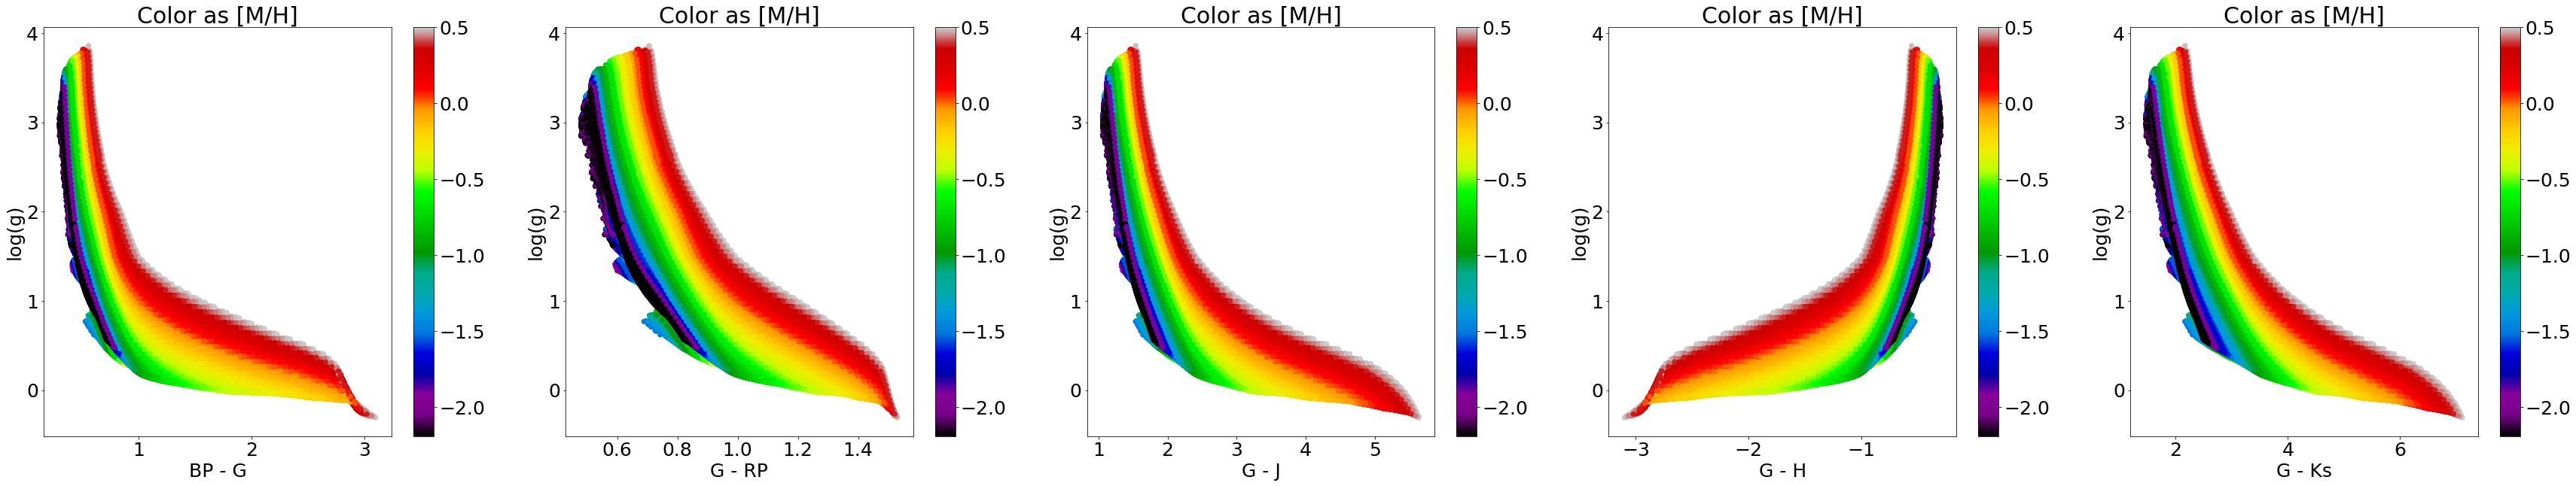

In [73]:
plt.figure(figsize=[60,10])

plt.subplot(151)
plt.scatter(massive['G_BPEDR3mag']-massive['GEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'BP - G')

plt.subplot(152)
plt.scatter(massive['GEDR3mag']-massive['G_RPEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - RP')

plt.subplot(153)
plt.scatter(massive['GEDR3mag']-massive['Jmag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - J')

plt.subplot(154)
plt.scatter(massive['GEDR3mag']-massive['G_BPEDR3mag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - H')

plt.subplot(155)
plt.scatter(massive['GEDR3mag']-massive['Ksmag'],massive['logg'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - Ks')

plt.show()

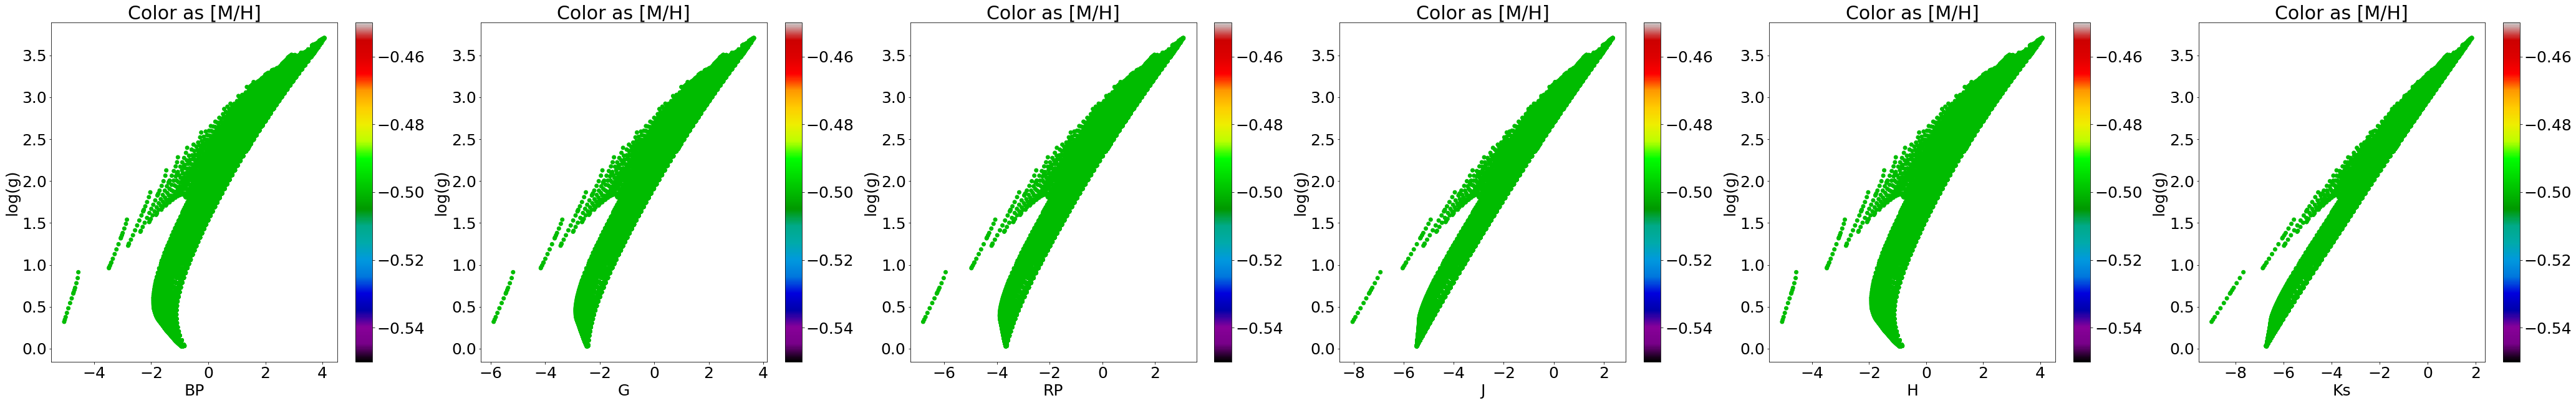

In [74]:
plt.figure(figsize=[72,10])

plt.subplot(161)
plt.scatter(singfeh['G_BPEDR3mag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'BP')

plt.subplot(162)
plt.scatter(singfeh['GEDR3mag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'G')

plt.subplot(163)
plt.scatter(singfeh['G_RPEDR3mag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'RP')

plt.subplot(164)
plt.scatter(singfeh['Jmag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'J')

plt.subplot(165)
plt.scatter(singfeh['G_BPEDR3mag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'H')

plt.subplot(166)
plt.scatter(singfeh['Ksmag'],singfeh['logg'],c=singfeh['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.ylabel(r'log(g)')
plt.xlabel(r'Ks')

plt.show()

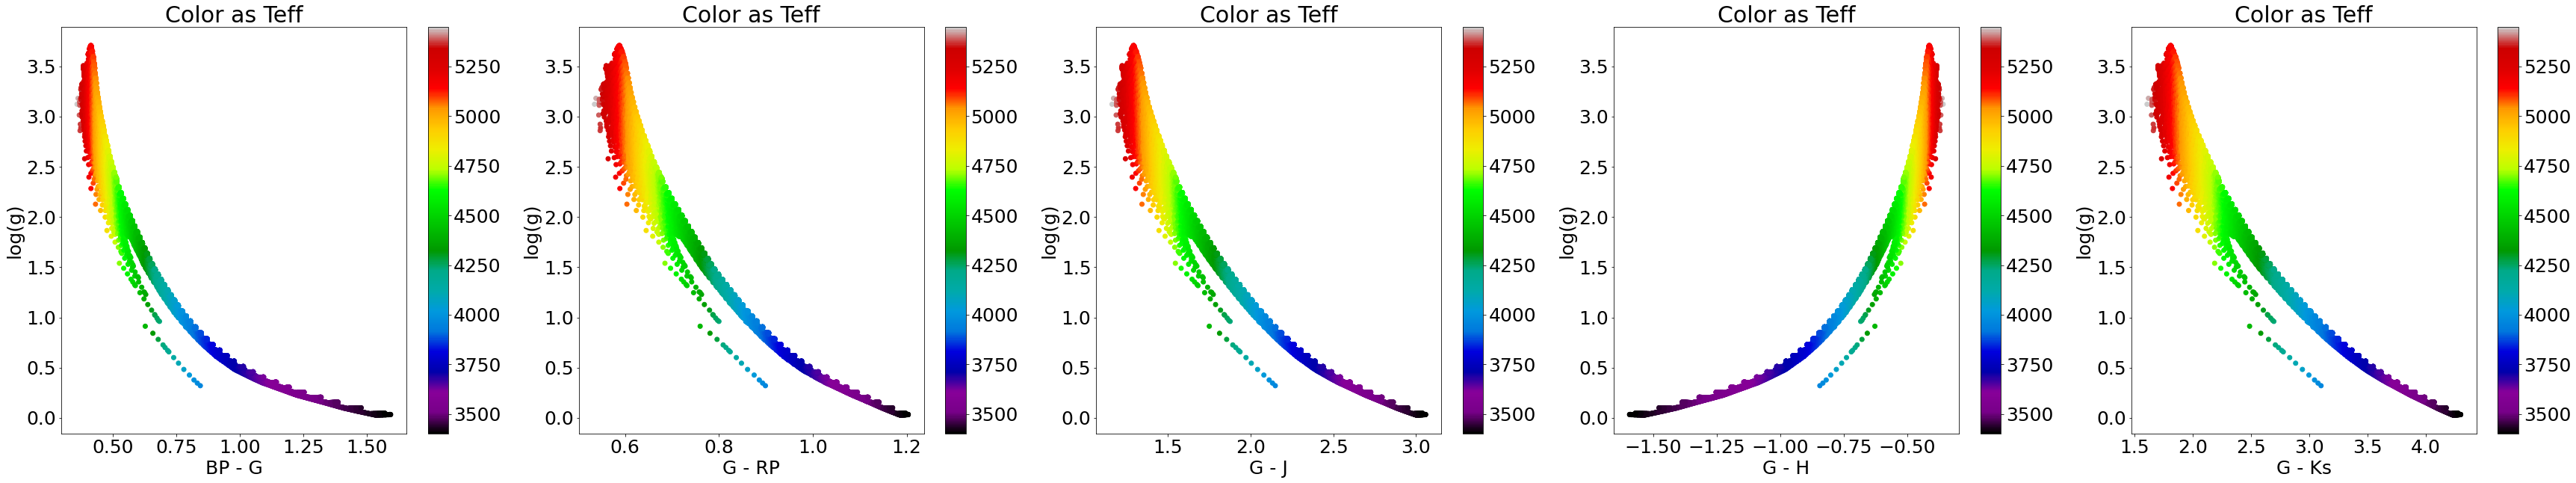

In [75]:
plt.figure(figsize=[60,10])

plt.subplot(151)
plt.scatter(singfeh['G_BPEDR3mag']-singfeh['GEDR3mag'],singfeh['logg'],c=10**singfeh['logTe'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.ylabel(r'log(g)')
plt.xlabel(r'BP - G')

plt.subplot(152)
plt.scatter(singfeh['GEDR3mag']-singfeh['G_RPEDR3mag'],singfeh['logg'],c=10**singfeh['logTe'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - RP')

plt.subplot(153)
plt.scatter(singfeh['GEDR3mag']-singfeh['Jmag'],singfeh['logg'],c=10**singfeh['logTe'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - J')

plt.subplot(154)
plt.scatter(singfeh['GEDR3mag']-singfeh['G_BPEDR3mag'],singfeh['logg'],c=10**singfeh['logTe'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - H')

plt.subplot(155)
plt.scatter(singfeh['GEDR3mag']-singfeh['Ksmag'],singfeh['logg'],c=10**singfeh['logTe'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.ylabel(r'log(g)')
plt.xlabel(r'G - Ks')

plt.show()

In [76]:
massive.columns

<TableColumns names=('MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag')>

# APOGEE

In [77]:
apo = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/apogee_library_dr17_rev1.fits')

# APOKASC

<ipython-input-78-73b505e18e76>:18: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


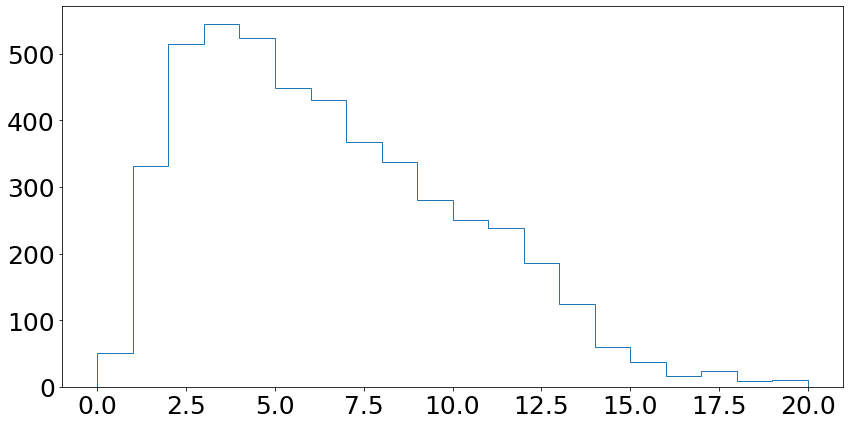

In [78]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')

# # Remove columns we don't need
# keepcols = ['apogee_id','telescope','location_id','field','ra','dec','j','j_err','h','h_err','k','k_err',
#             'ak_targ','ak_wise','sfd_ebv','nvisits','snr','gaiaedr3_source_id','gaiaedr3_source_id',
#             'gaiaedr3_pmra','gaiaedr3_pmdec','gaiaedr3_parallax','gaiaedr3_phot_g_mean_mag',
#             'gaiaedr3_phot_bp_mean_mag','gaiaedr3_phot_rp_mean_mag','starflag','starflags','aspcapflag',
#             'aspcapflags','aspcap_chi2','fparam','teff','teff_err','teff_spec','logg','logg_err','logg_spec',
#             'm_h','m_h_err','fe_h','fe_h_err','alpha_m','alpha_m_err']
# remcols = []
# for c in dr17.colnames:
#     if c not in keepcols:
#         remcols.append(c)
# dr17.remove_columns(remcols)

# Calculate [alpha/Fe]
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&np.isfinite(kdr17['fe_h']))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

good, = np.where((kdr17['SNR']>50) & (kdr17['TELESCOPE']!='apo1m') & np.isfinite(kdr17['TEFF']) &
                 np.isfinite(kdr17['LOGG']) & ((kdr17['STARFLAG'] & 2**9)<=0) &
                 ((kdr17['ASPCAPFLAG'] & 2**24)<=0))

k674 = k674[good]
kdr17 = kdr17[good]
apoafe = apoafe[good]
apoafe_err = apoafe_err[good]
salfeh = salfeh[good]
salfeh_err = salfeh_err[good]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

In [79]:
# dr17 = Table.read('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')

# good, = np.where((dr17['SNR']>50) & (dr17['TELESCOPE']!='apo1m') & np.isfinite(dr17['TEFF']) &
#                  np.isfinite(dr17['LOGG']) & ((dr17['STARFLAG'] & 2**9)<=0) &
#                  ((dr17['ASPCAPFLAG'] & 2**24)<=0))
# # STARFLAG    9, persist_high
# # ASPCAPFLAG 24, chi2_bad
# calib = dr17[good]
# for c in calib.colnames: calib[c].name = c.lower()

In [80]:
# # Remove columns we don't need
# keepcols = ['apogee_id','telescope','location_id','field','ra','dec','j','j_err','h','h_err','k','k_err','ak_targ','ak_wise','sfd_ebv',
#            'nvisits','snr','gaiaedr3_source_id','gaiaedr3_source_id','gaiaedr3_pmra','gaiaedr3_pmdec','gaiaedr3_parallax',
#            'gaiaedr3_phot_g_mean_mag','gaiaedr3_phot_bp_mean_mag','gaiaedr3_phot_rp_mean_mag',
#            'starflag','starflags','aspcapflag','aspcapflags','aspcap_chi2',
#            'fparam','teff','teff_err','teff_spec','logg','logg_err','logg_spec','m_h','m_h_err','fe_h','fe_h_err','alpha_m','alpha_m_err']
# remcols = []
# for c in calib.colnames:
#     if c not in keepcols:
#         remcols.append(c)
# calib.remove_columns(remcols)

In [81]:
# # Find duplicate APOGEE_IDs
# index = dln.create_index(calib['apogee_id'].data)
# bad, = np.where(index['num']>1)
# print(len(bad),' duplicates')
# torem = []
# for i in range(len(bad)):
#     ind = index['index'][index['lo'][bad[i]]:index['hi'][bad[i]]+1]
#     snr = calib['snr'][ind]
#     si = np.flip(np.argsort(snr))
#     torem += list(ind[si[1:]])
#     #print(index['value'][bad[i]],len(ind))

In [82]:
# calib.remove_rows(np.array(torem))

In [83]:
# index2 = dln.create_index(calib['apogee_id'].data)
# bad2, = np.where(index2['num']>1)
# print(len(bad2),' duplicates')

In [84]:
# # Save the final catalog
# print(len(calib),' final stars')
# calib.write('/Users/joshuapovick/Desktop/Research/fits/apogee_library_dr17_rev1.fits',overwrite=True)

In [85]:
# plt.figure(figsize=[12,10])
# plt.scatter(calib['fparam'][:,0],calib['fparam'][:,1],c=calib['fparam'][:,3],cmap='nipy_spectral')
# plt.colorbar()
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xlabel(r'teff')
# plt.ylabel(r'logg')
# plt.show()

In [86]:
# plt.figure(figsize=[12,10])
# plt.scatter(calib['teff'],calib['logg'],c=calib['fe_h'],cmap='nipy_spectral')
# plt.colorbar()
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xlabel(r'teff')
# plt.ylabel(r'logg')
# plt.show()

In [87]:
# # J\"{o}nsson et al. 2020 (https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf)

# # modified so that minimum uncalibrated log(g) of RC is 2.0

# cn = calib['fparam'][:,4]-calib['fparam'][:,5]
# dt = calib['teff_spec'] - (4400.+552.6*(calib['logg_spec']-2.5)-324.6*calib['fparam'][:,3])

# rc = calib[np.where((calib['fparam'][:,1]>1.5)&(calib['fparam'][:,1]<3.5)&
#                    (cn>0.04-0.46*calib['fparam'][:,3]-0.0028*dt))]

# rgb = calib[np.where((calib['fparam'][:,1]<3.5)&(calib['fparam'][:,0]<6000.)&
#                     (np.isin(calib['apogee_id'],rc['apogee_id'])==False))]

# # Get rid of high extinction stars
# rgb = rgb[np.where((rgb['sfd_ebv']<0.03))]

In [88]:
# ### Salaris Correction
# afe = rgb['alpha_m']+rgb['m_h']-rgb['fe_h'] # [alpha/Fe]
# afe_err = np.sqrt(rgb['alpha_m']**2+rgb['m_h']**2-rgb['fe_h']**2) # [alpha/Fe] err

# # 0.659, 0.341 from Asplund et al 2021.
# salfeh = rgb['fe_h']+np.log10(0.659*(10**(afe))+0.341)
# salfeh_err = np.sqrt(rgb['fe_h_err']**2+
#                              ((1-0.341/(0.659*(10**(afe))+0.341))*afe_err)**2)

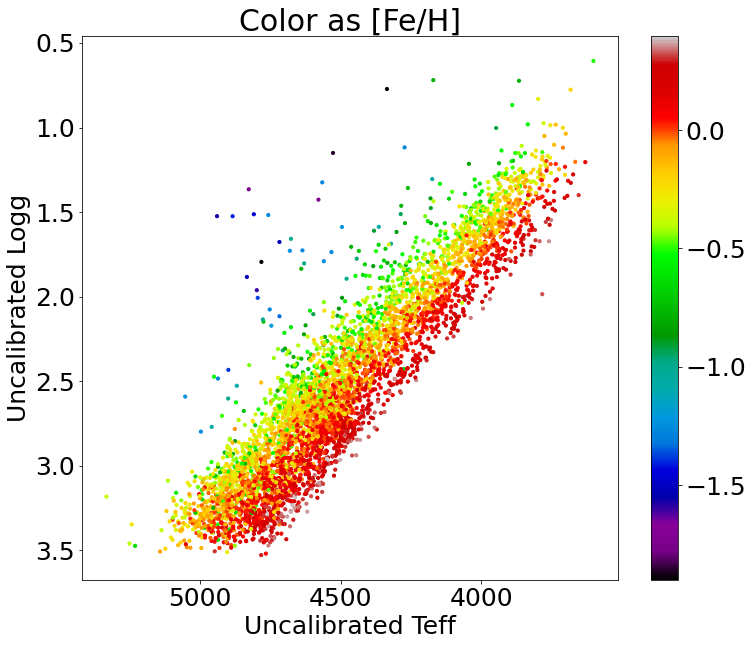

In [89]:
plt.figure(figsize=[12,10])
# plt.scatter(kdr17['teff'],kdr17['logg'],c=kdr17['fe_h'],cmap='nipy_spectral',s=10)
plt.scatter(kdr17['FPARAM'][:,0],kdr17['FPARAM'][:,1],c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()

# plt.text(5900,0,r'E(B-V)$_{\rm SFD}$ < 0.03')

# high logg cut
# plt.plot([3500,4350],[2.75,2.75],c='tab:purple',lw=3.0)
# plt.plot([4350,4700],[2.75,3.5],c='tab:purple',lw=3.0)
# plt.plot([4700,5600],[3.5,3.5],c='tab:purple',lw=3.0)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Uncalibrated Logg')
plt.show()

In [90]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

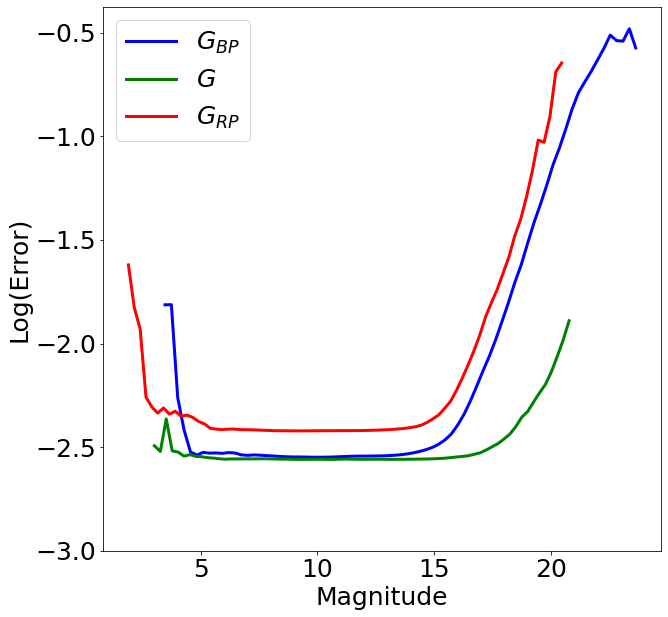

In [91]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_MEAN_MAG'])==True)

bpmin = min(gaiaedr3['phot_bp_MEAN_MAG'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_MEAN_MAG'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_MEAN_MAG'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_MEAN_MAG'])==True)

gmin = min(gaiaedr3['phot_g_MEAN_MAG'][g_fin])
gmax = max(gaiaedr3['phot_g_MEAN_MAG'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_MEAN_MAG'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_MEAN_MAG'])==True)

rpmin = min(gaiaedr3['phot_rp_MEAN_MAG'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_MEAN_MAG'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_MEAN_MAG'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = dln.bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = dln.bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = dln.bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

In [92]:
# k674.columns

In [93]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

# photteffs = 999999.0*np.ones(len(np.squeeze(rgb)))
# photteffs_err = 999999.0*np.ones(len(np.squeeze(rgb)))
# ghbteffs = 999999.0*np.ones(len(np.squeeze(rgb)))
# ghbteffs_err = 999999.0*np.ones(len(np.squeeze(rgb)))

# for i in tqdm(range(len(np.squeeze(rgb)))):

#     op = np.array([[rgb['gaiaedr3_phot_bp_mean_mag'][i],
#                     rgb['gaiaedr3_phot_g_mean_mag'][i],
#                     rgb['gaiaedr3_phot_rp_mean_mag'][i],
#                     rgb['j'][i],rgb['h'][i],
#                     rgb['k'][i]],
#                    [bperr[i],gerr[i],rperr[i],
#                     rgb['j_err'][i],rgb['h_err'][i],
#                     rgb['k_err'][i]]]).T
    
#     photteffs[i], photteffs_err[i] = color_teff(op,salfeh[i],massive)
    
    
#     jk = np.array([rgb['j'][i]-rgb['k'][i],np.sqrt(rgb['j_err'][i]**2+rgb['k'][i]**2)])
#     sfeh = np.array([salfeh[i],salfeh_err[i]])
    
#     ghbteffs[i], ghbteffs_err[i] = ghb_jk_teff(jk,sfeh)

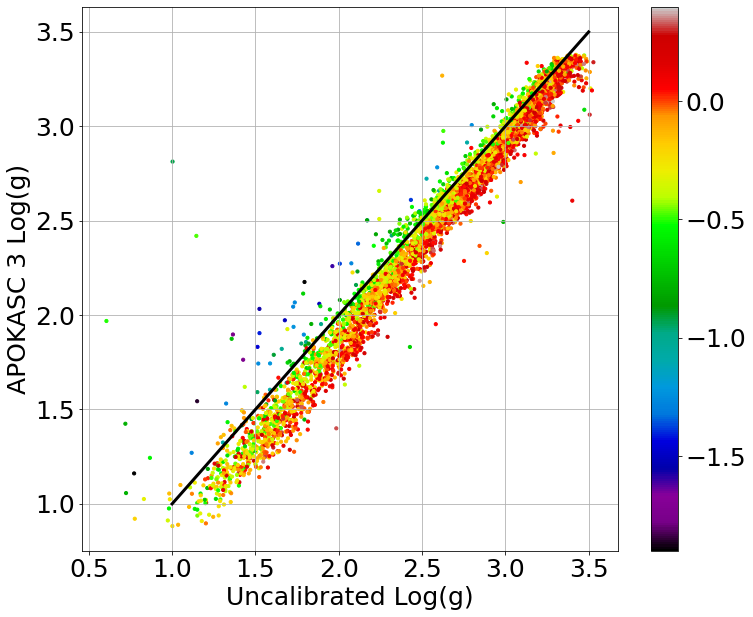

In [94]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG'],c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([1,3.5],[1,3.5],c='k',lw=3.0)
plt.grid()
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'APOKASC 3 Log(g)')
plt.show()

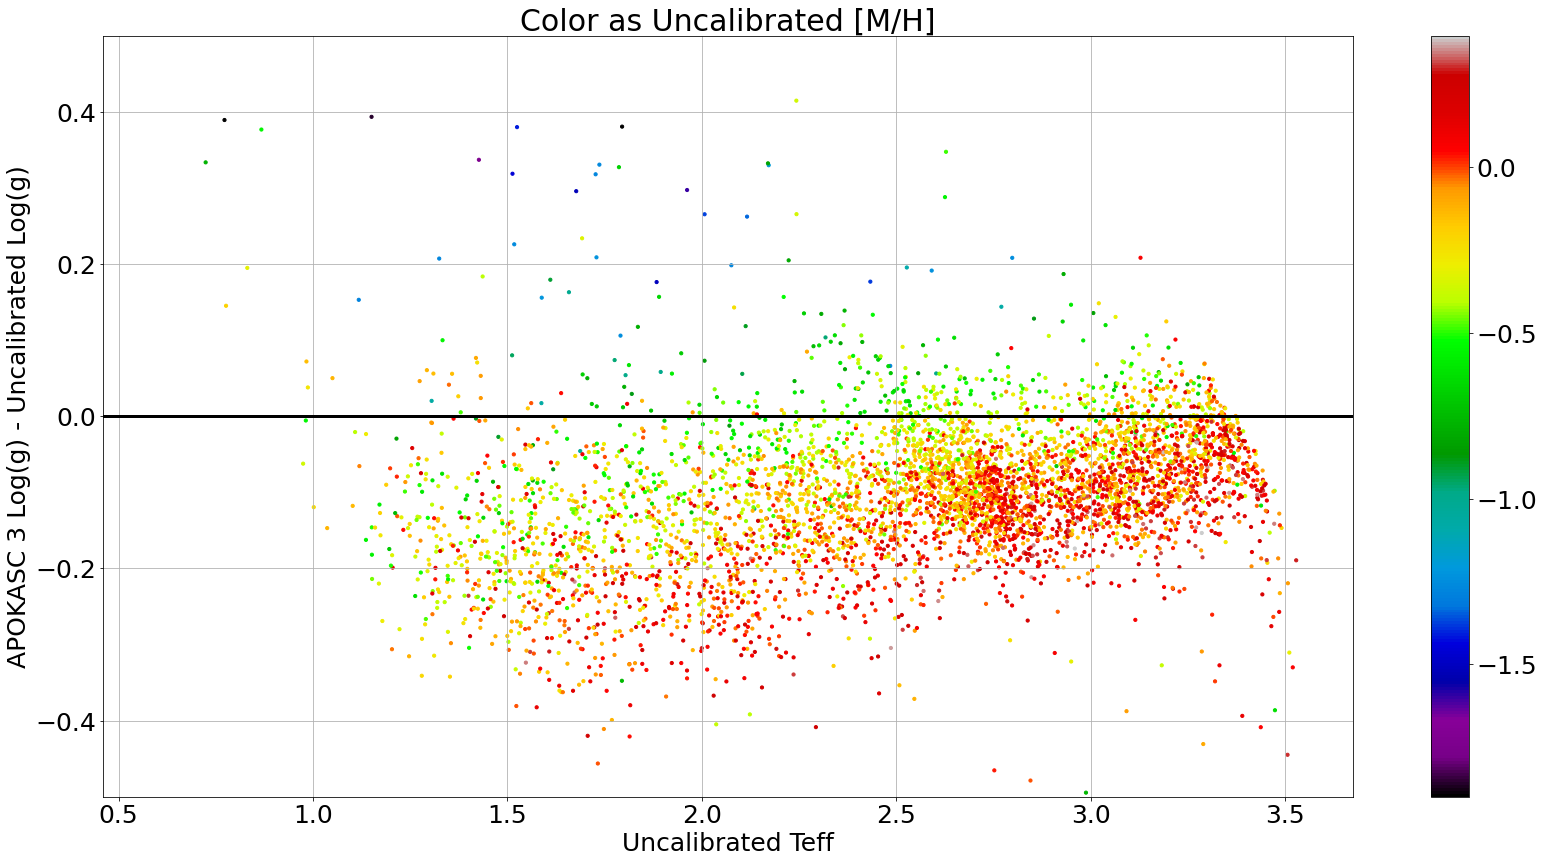

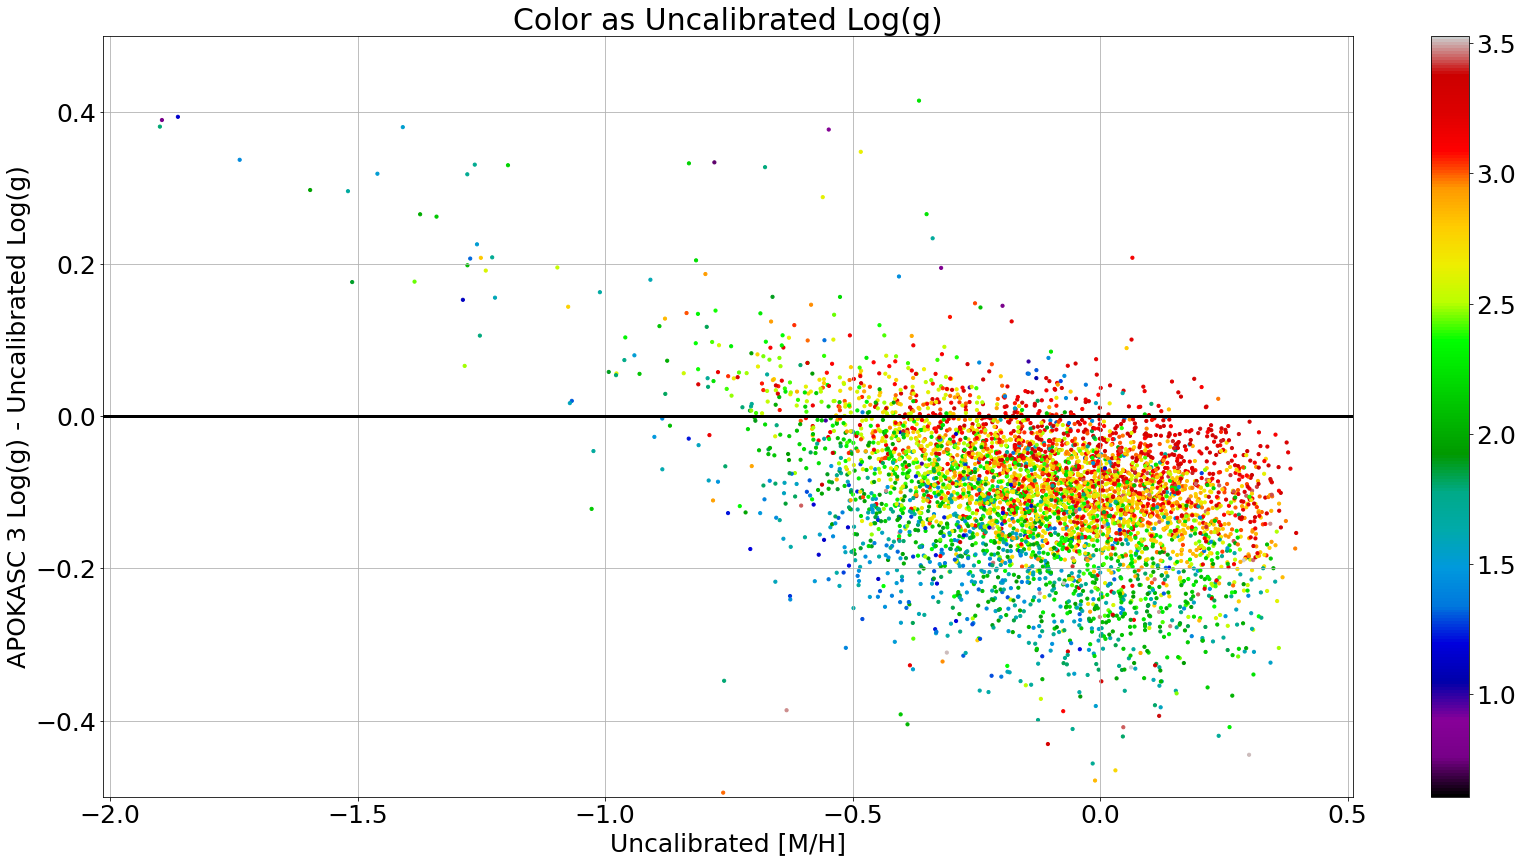

In [95]:
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-0.5,0.5)
plt.grid()
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.show()

###
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,3],k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            c=kdr17['FPARAM'][:,1],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-0.5,0.5)
plt.grid()
plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.show()

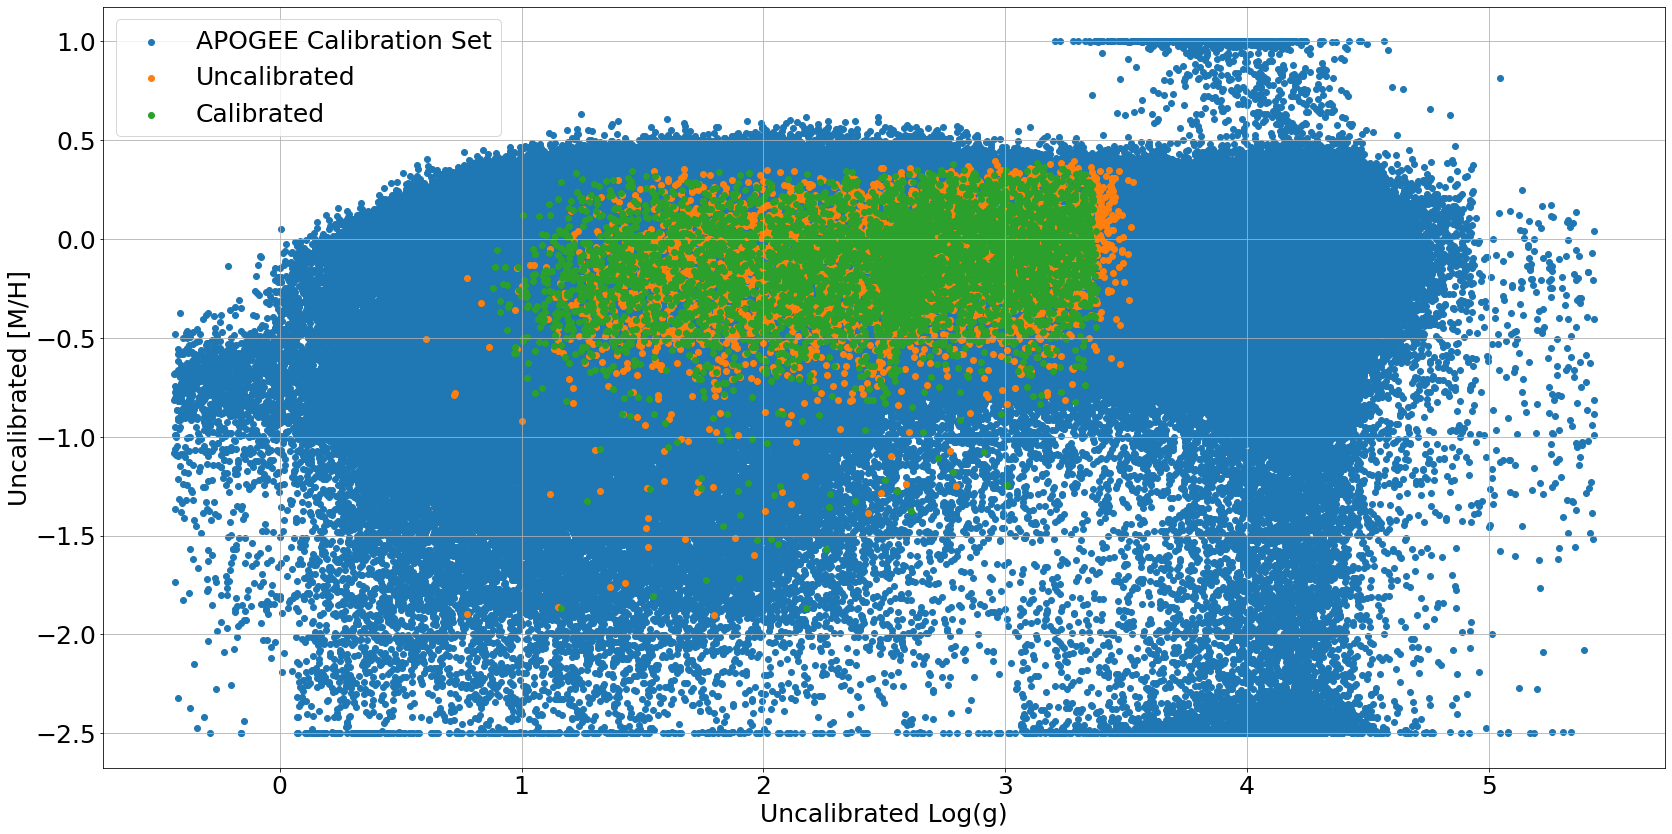

In [96]:
plt.figure(figsize=[28,14])
plt.scatter(apo['FPARAM'][:,1],apo['FPARAM'][:,3],label='APOGEE Calibration Set')
plt.scatter(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3],label='Uncalibrated')#,c=k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1]#,
#             cmap='nipy_spectral',s=10,vmin=-0.5,vmax=0.5)
# plt.colorbar()
plt.scatter(k674['APOKASC3P_LOGG'],kdr17['FE_H'],label='Calibrated')
plt.legend()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
# plt.title(r'Color as APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.show()

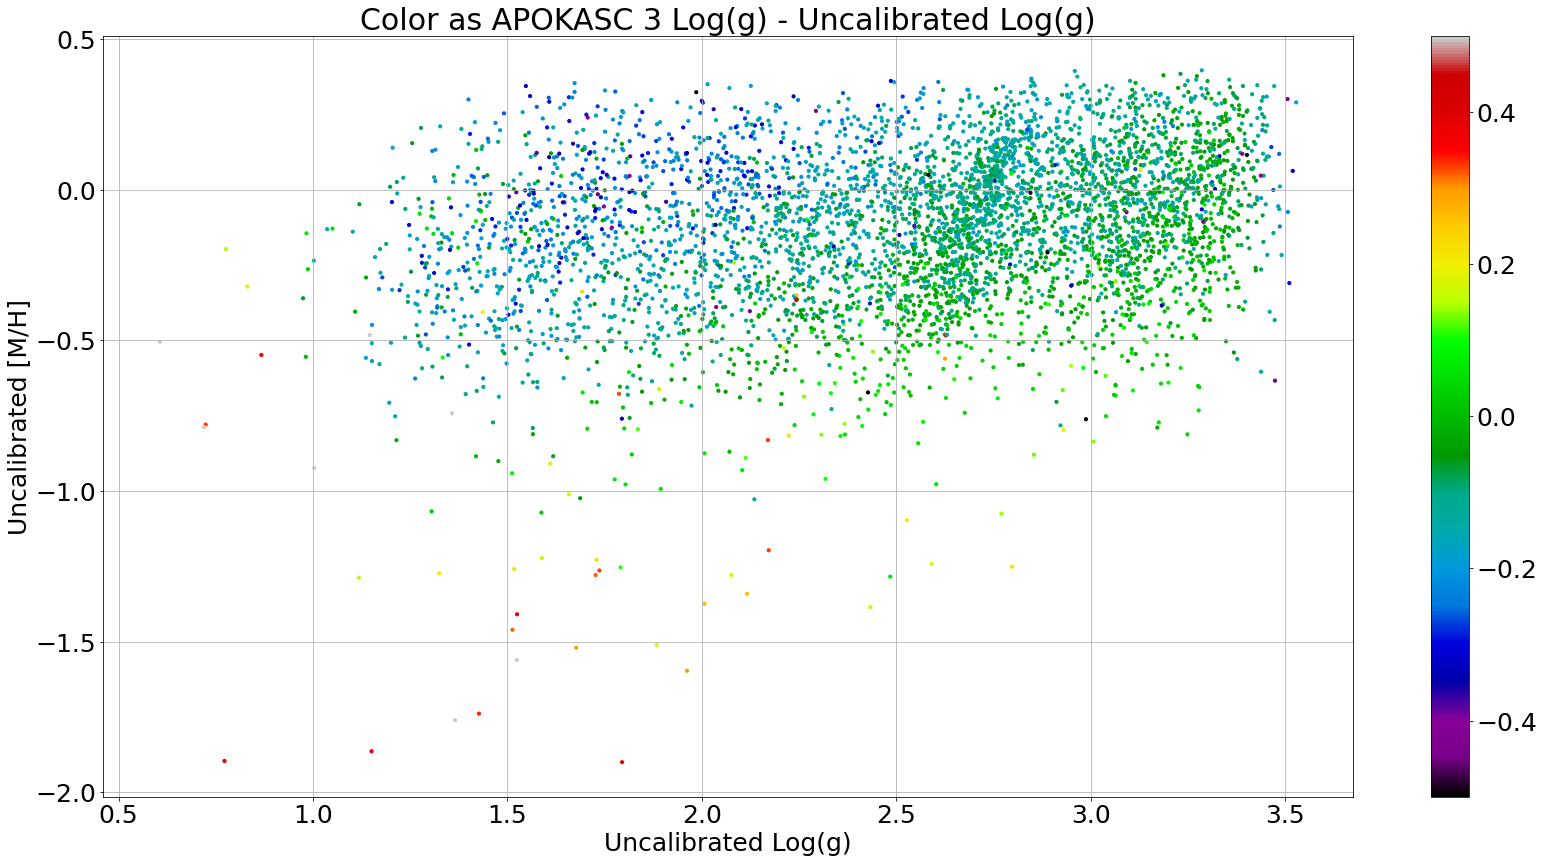

In [97]:
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3],c=k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],
            cmap='nipy_spectral',s=10,vmin=-0.5,vmax=0.5)
plt.colorbar()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.title(r'Color as APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.show()

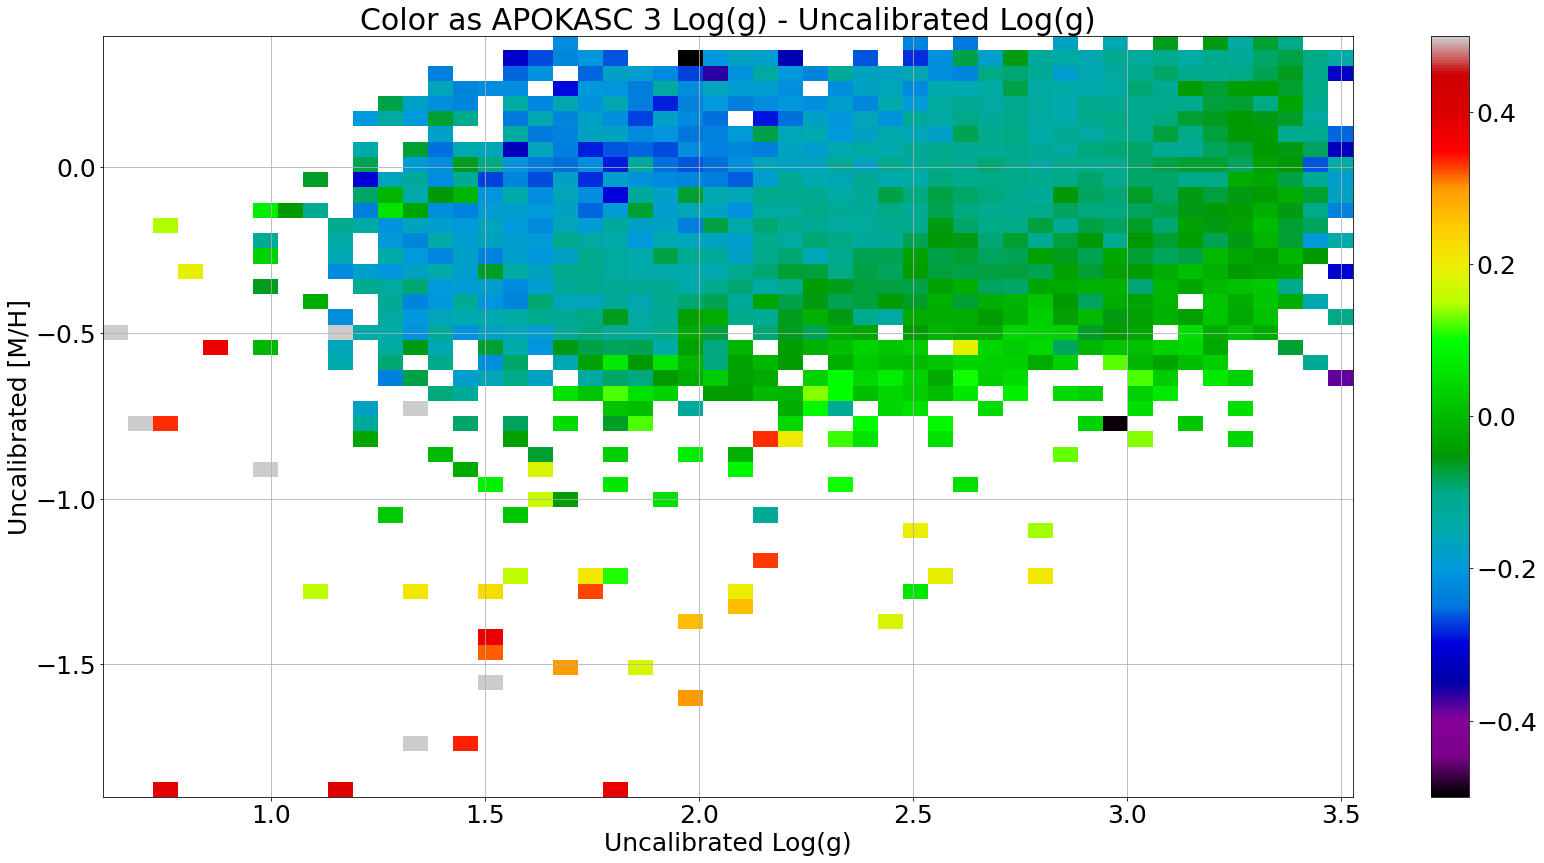

In [98]:
plt.figure(figsize=[28,14])

logg_ret = binned_statistic_2d(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3],
                               k674['APOKASC3P_LOGG']-kdr17['FPARAM'][:,1],'median',bins=50)

logg_ret.statistic[logg_ret.statistic == 0.0] = np.nan

im = plt.imshow(logg_ret.statistic.T, origin='lower',
                extent=[logg_ret.x_edge[0],logg_ret.x_edge[-1],
                        logg_ret.y_edge[0],logg_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=-0.5,vmax=0.5)

plt.colorbar()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.title(r'Color as APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.savefig('uncal_feh_logg_dlogg.png',bbox_inches='tight')
plt.show()

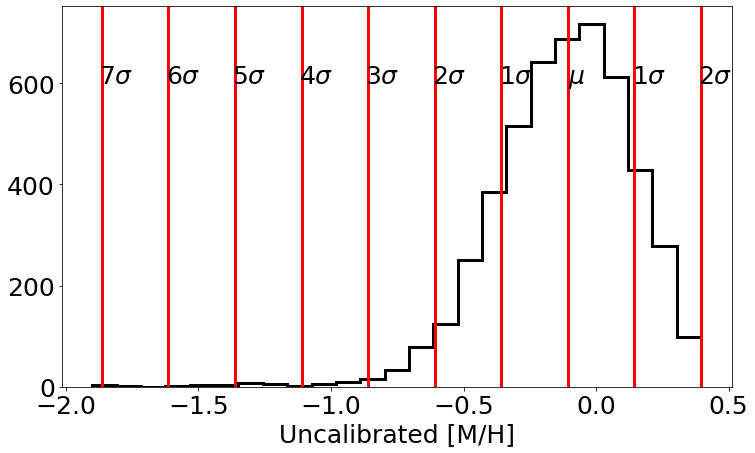

848
4064


In [99]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['FPARAM'][:,3],color='k',lw=3.0,histtype='step',bins=25)

plt.axvline(np.median(kdr17['FPARAM'][:,3]),c='r',lw=3.0)
plt.text(np.median(kdr17['FPARAM'][:,3]),600,r'$\mu$')

for i in np.delete(range(8),0):
    if i > 2:
        plt.axvline(np.median(kdr17['FPARAM'][:,3])-i*dln.mad(kdr17['FPARAM'][:,3]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,3])-i*dln.mad(kdr17['FPARAM'][:,3])-.01,600,r'{}$\sigma$'.format(i))
    
    else:
        plt.axvline(np.median(kdr17['FPARAM'][:,3])-i*dln.mad(kdr17['FPARAM'][:,3]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,3])-i*dln.mad(kdr17['FPARAM'][:,3])-.01,600,r'{}$\sigma$'.format(i))
        
        plt.axvline(np.median(kdr17['FPARAM'][:,3])+i*dln.mad(kdr17['FPARAM'][:,3]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,3])+i*dln.mad(kdr17['FPARAM'][:,3])-.01,600,r'{}$\sigma$'.format(i))
        
plt.xlabel(r'Uncalibrated [M/H]')
plt.show()

print(len(np.squeeze(np.where(kdr17['FPARAM'][:,3]<-0.3575227796566287))))
print(len(np.squeeze(np.where(kdr17['FPARAM'][:,3]>-0.3575227796566287))))

In [100]:
print('[M/H] 1 sigma less',np.median(kdr17['FPARAM'][:,3])-1*dln.mad(kdr17['FPARAM'][:,3]))

[M/H] 1 sigma less -0.3575227796566287


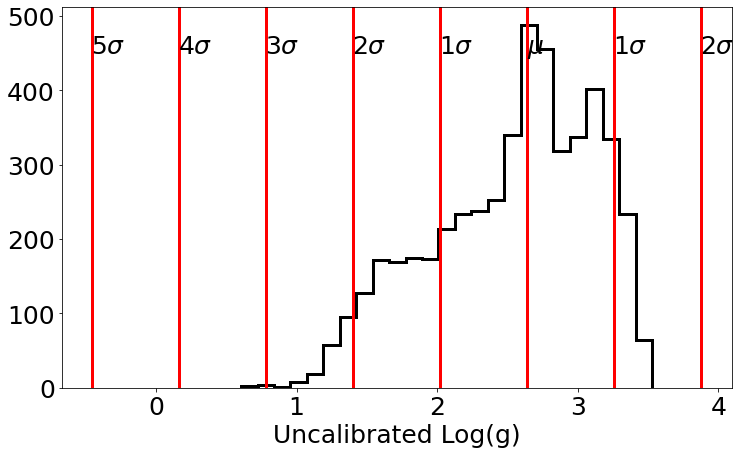

981
3931


In [101]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['FPARAM'][:,1],color='k',lw=3.0,histtype='step',bins=25)

plt.axvline(np.median(kdr17['FPARAM'][:,1]),c='r',lw=3.0)
plt.text(np.median(kdr17['FPARAM'][:,1]),450,r'$\mu$')

for i in np.delete(range(6),0):
    if i > 2:
        plt.axvline(np.median(kdr17['FPARAM'][:,1])-i*dln.mad(kdr17['FPARAM'][:,1]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,1])-i*dln.mad(kdr17['FPARAM'][:,1])-.01,450,r'{}$\sigma$'.format(i))
    
    else:
        plt.axvline(np.median(kdr17['FPARAM'][:,1])-i*dln.mad(kdr17['FPARAM'][:,1]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,1])-i*dln.mad(kdr17['FPARAM'][:,1])-.01,450,r'{}$\sigma$'.format(i))
        
        plt.axvline(np.median(kdr17['FPARAM'][:,1])+i*dln.mad(kdr17['FPARAM'][:,1]),c='r',lw=3.0)
        plt.text(np.median(kdr17['FPARAM'][:,1])+i*dln.mad(kdr17['FPARAM'][:,1])-.01,450,r'{}$\sigma$'.format(i))
        
plt.xlabel(r'Uncalibrated Log(g)')
plt.show()


print(len(np.squeeze(np.where(kdr17['FPARAM'][:,1]<2))))
print(len(np.squeeze(np.where(kdr17['FPARAM'][:,1]>2))))

In [102]:
print('Log(g) 1 sigma less',np.median(kdr17['FPARAM'][:,1])-3*dln.mad(kdr17['FPARAM'][:,1]))

Log(g) 1 sigma less 0.784653106441435


In [103]:
def dlogg(X,a,b,c,d,e):
    logg, mh = X
    return (a + b*np.maximum(logg,2.0) + c*np.maximum(logg,2.0)**2 + d*np.maximum(logg,2.0)**3 + 
            e*np.maximum(mh,-0.358))

popt_dlogg, pcov_dlogg = curve_fit(dlogg, (kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]), 
                                   k674['APOKASC3P_LOGG'] - kdr17['FPARAM'][:,1])

In [104]:
dlogg

<function __main__.dlogg(X, a, b, c, d, e)>

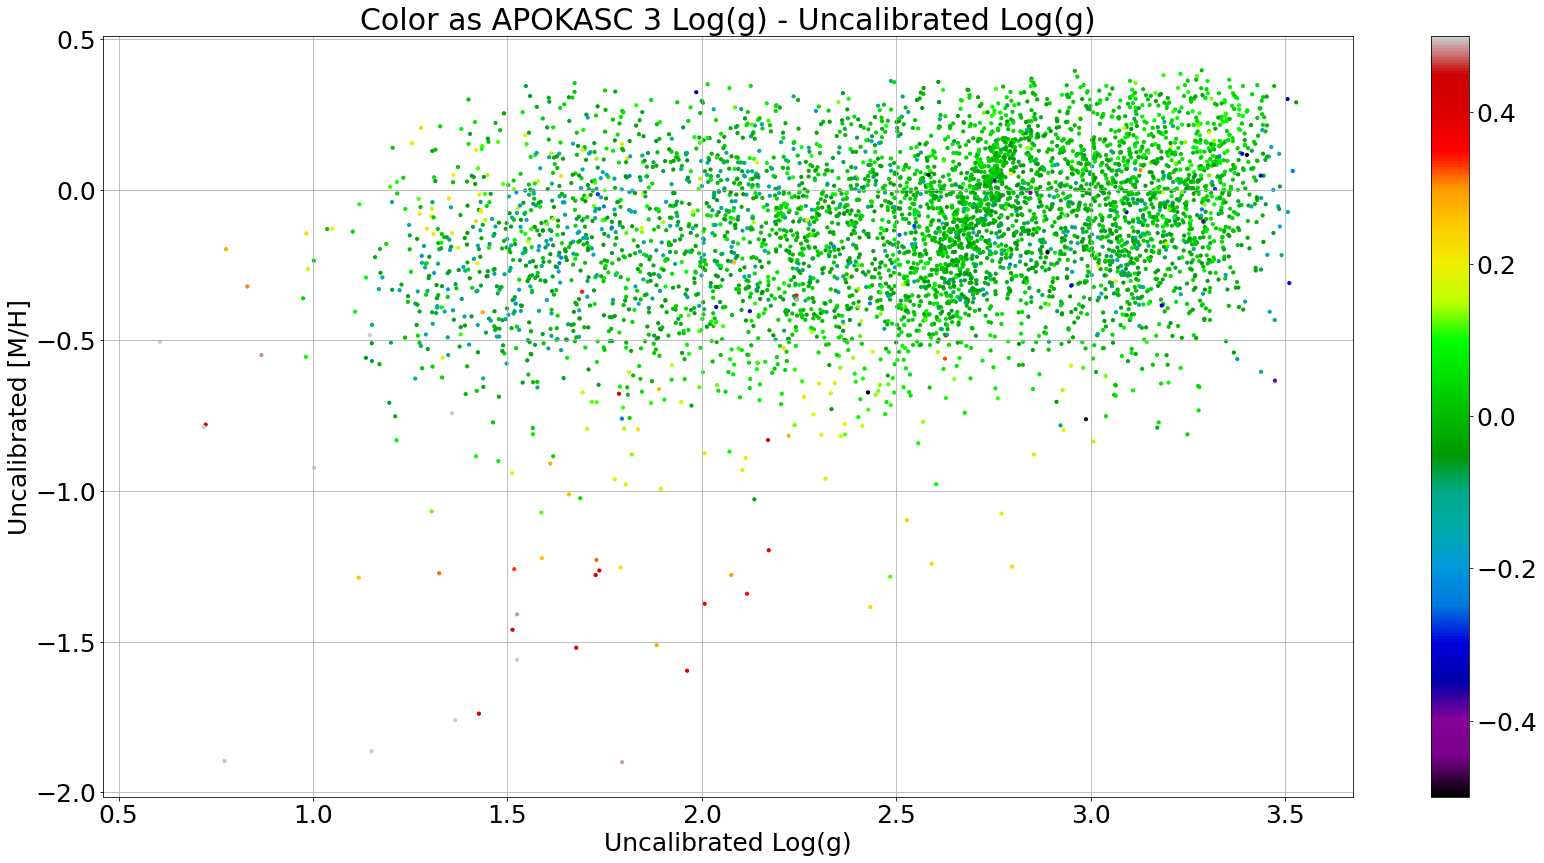

In [105]:
plt.figure(figsize=[28,14])
plt.scatter(kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3],
            c=k674['APOKASC3P_LOGG']-(kdr17['FPARAM'][:,1]+dlogg((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_dlogg)),
            cmap='nipy_spectral',s=10,vmin=-0.5,vmax=0.5)
plt.colorbar()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.title(r'Color as APOKASC 3 Log(g) - Uncalibrated Log(g)')
plt.show()

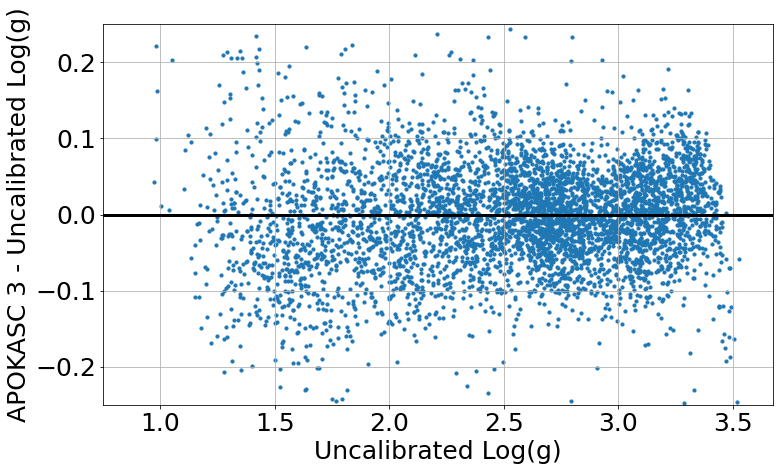

-0.105285645
0.6466238118245972


In [106]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k674['APOKASC3P_LOGG']-(kdr17['FPARAM'][:,1]+dlogg((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_dlogg)),s=10)
plt.axhline(0,c='k',lw=3.0)
plt.ylim(-0.25,0.25)
plt.xlim(left=0.75)
plt.grid()
plt.ylabel(r'APOKASC 3 - Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated Log(g)')
plt.show()
print(np.nanmedian(dlogg((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_dlogg)))
print(dln.mad(kdr17['FPARAM'][:,1]+dlogg((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_dlogg)))

Median Residual 0.00522 +/ 0.09204


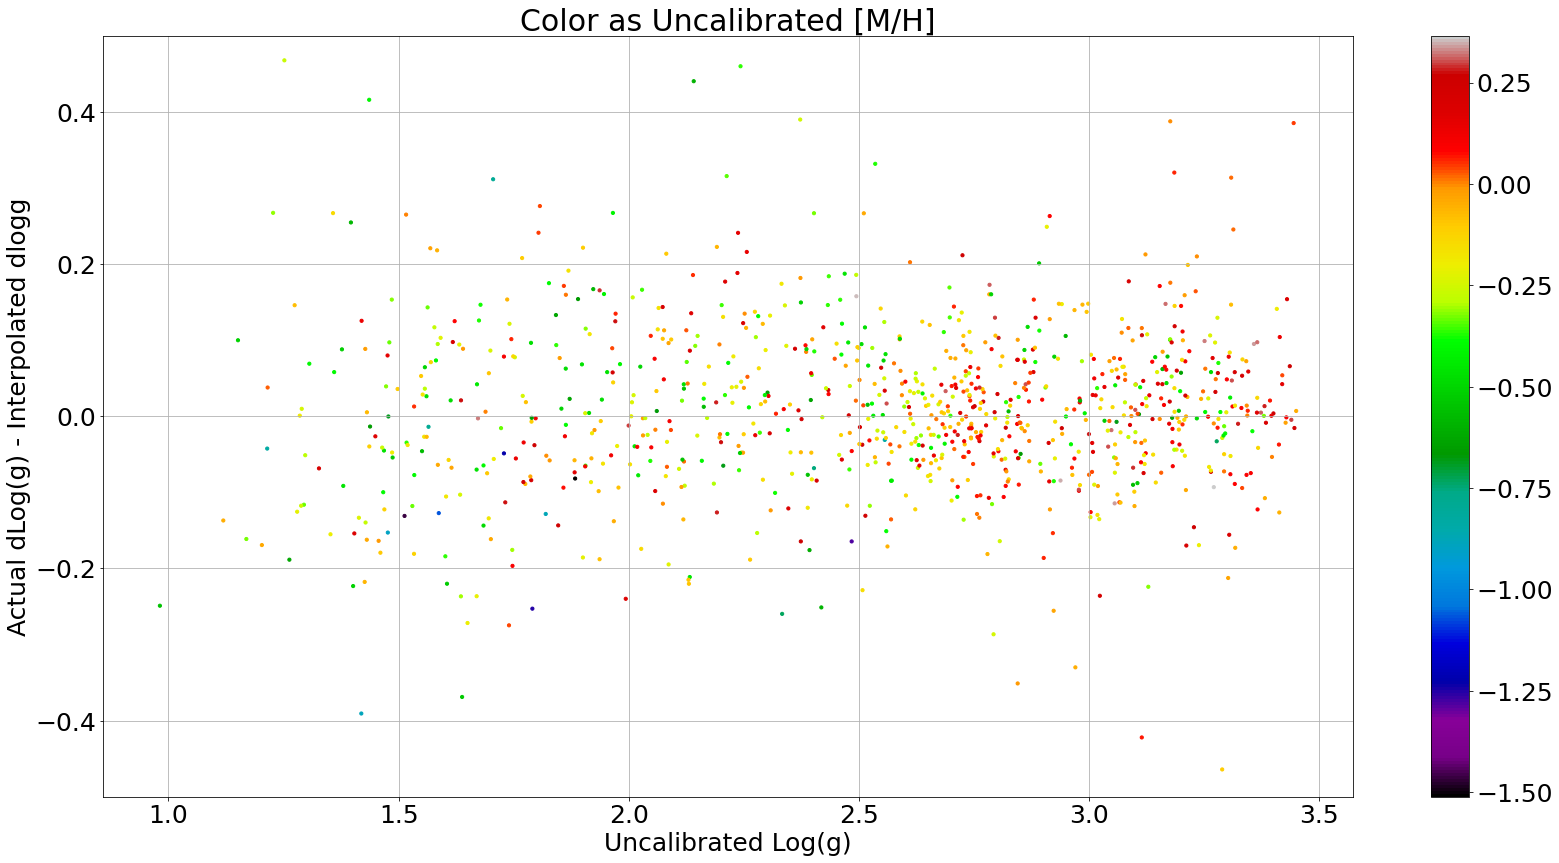

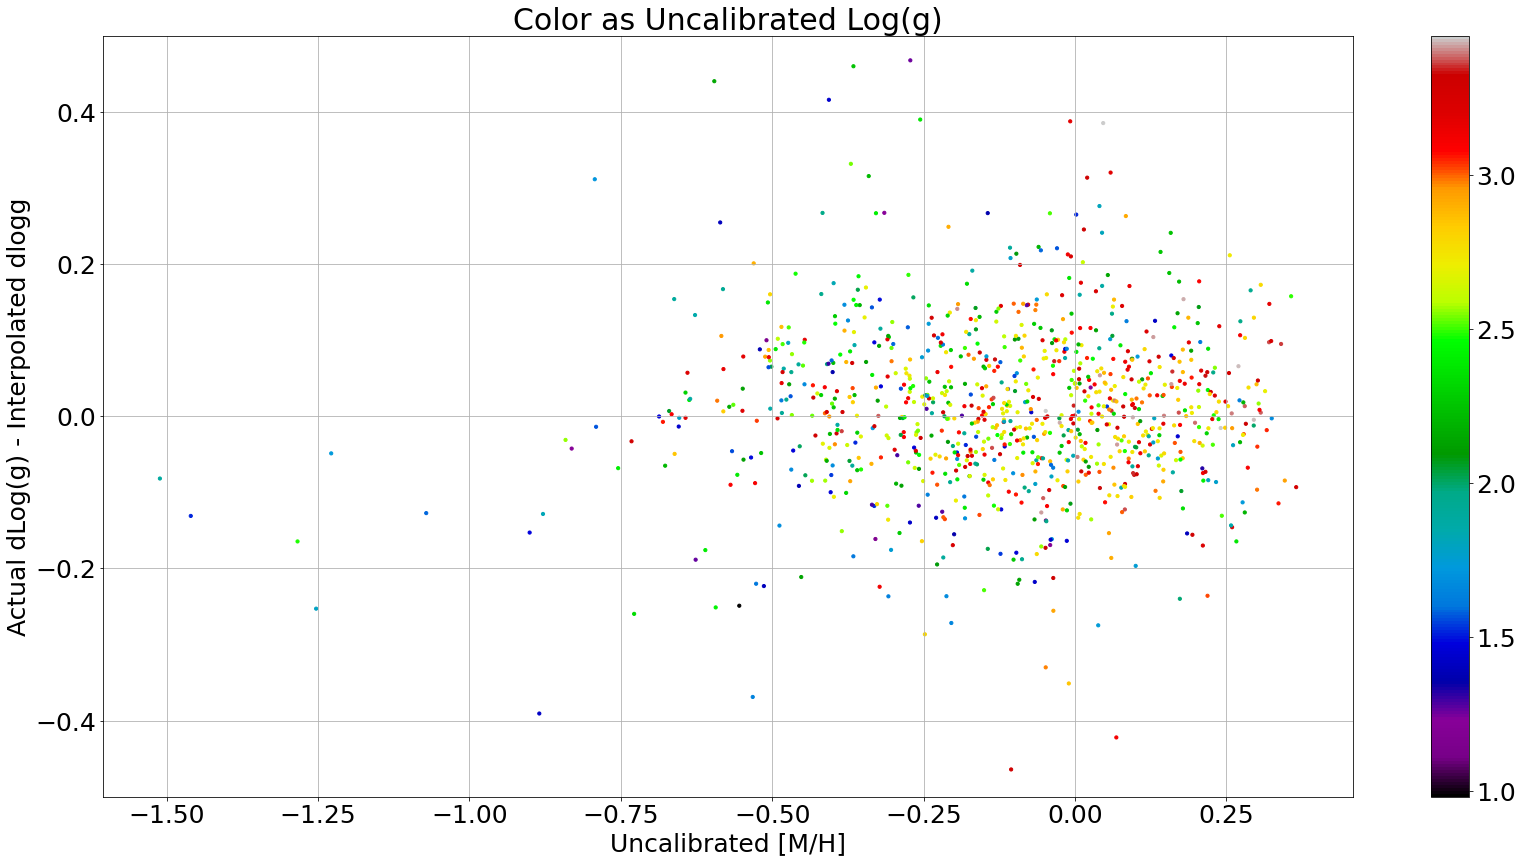

In [107]:
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

logg_feh = np.array([kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]]).T
dlogg = k674['APOKASC3P_LOGG'] - kdr17['FPARAM'][:,1]

logg_feh_train, logg_feh_test, dlogg_train, dlogg_test = train_test_split(
logg_feh, dlogg, test_size=0.20)


### Fit Bicubic Spline with train data

fincut_train = np.where((np.isfinite(logg_feh_train[:,0])==True)&(np.isfinite(logg_feh_train[:,1])==True)&
                        (np.isfinite(dlogg_train)==True))

interp_dlogg = griddata(logg_feh_train[fincut_train],dlogg_train[fincut_train],
                        (logg_feh_test[:,0],logg_feh_test[:,1]),method='cubic')

# plt.figure(figsize=[10,10])
# plt.scatter(dlogg_test,interp_dlogg)
# plt.xlim(-200,600)
# plt.ylim(-600,600)
# plt.xlabel(r'PARSEC Photometric - Uncalibrated logg')
# plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated logg')
# plt.show()

# plt.figure(figsize=[28,14])
# plt.scatter(logg_feh_test[:,0],interp_dlogg)
# plt.ylim(-0.5,0.5)
# plt.xlabel(r'Uncalibrated logg')
# plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated logg')
# plt.show()

# plt.figure(figsize=[28,14])
# plt.scatter(logg_feh_test[:,1],interp_dlogg)
# plt.ylim(-0.5,0.5)
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated logg')
# plt.show()

###############################

print(r'Median Residual {:.5f} +/ {:.5f}'.format(np.nanmedian(dlogg_test - interp_dlogg),dln.mad(dlogg_test - interp_dlogg)))

plt.figure(figsize=[28,14])
plt.scatter(logg_feh_test[:,0], dlogg_test - interp_dlogg, c = logg_feh_test[:,1], cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.5,0.5)
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'Actual dLog(g) - Interpolated dlogg')
plt.grid()
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(logg_feh_test[:,1],dlogg_test - interp_dlogg, c = logg_feh_test[:,0], cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.5,0.5)
plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Actual dLog(g) - Interpolated dlogg')
plt.grid()
plt.show()

In [108]:
griddata(logg_feh_train[fincut_train],dlogg_train[fincut_train],(1.5,-2.5),method='cubic')

array(nan)

In [109]:
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,0],photteffs-new_teff,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# # plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Teff')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

# ###
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,3],photteffs-new_teff,c=rgb['fparam'][:,0],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# # plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated Teff')
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

In [110]:
# import numpy as np
# from scipy.interpolate import interp2d
# import matplotlib.pyplot as plt

# x = rgb['fparam'][:,0]
# y = rgb['fparam'][:,3]
# X, Y = np.meshgrid(x, y)
# Z = photteffs-rgb['fparam'][:,0] #np.sin(np.pi*X/2) * np.exp(Y/2)

# x2 = np.linspace(3500, 5500, 100)
# y2 = np.linspace(-2.5, 0.6, 100)
# f = interp2d(x, y, Z, kind='cubic')
# Z2 = f(x2, y2)

# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].pcolormesh(X, Y, Z, cmap='nipy_spectral')

# X2, Y2 = np.meshgrid(x2, y2)
# ax[1].pcolormesh(X2, Y2, Z2, cmap='nipy_spectral')

# plt.show()


In [111]:
# np.sin(np.pi*X/2) * np.exp(Y/2)

In [112]:
# from scipy.interpolate import interp2d

# fincut = np.where((np.isfinite(rgb['fparam'][:,0])==True)&(np.isfinite(rgb['fparam'][:,3])==True)&
#                   (np.isfinite(photteffs)==True))

# xx, yy = np.meshgrid(rgb['fparam'][:,0][fincut],rgb['fparam'][:,3][fincut])
# # f = interp2d(xx,yy,(photteffs-rgb['fparam'][:,0])[fincut],kind='cubic')

In [113]:
# def func(x, y):
#     return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

# rng = np.random.default_rng()
# points = rng.random((1000, 2))
# values = func(points[:,0], points[:,1])

In [114]:
# fincut = np.where((np.isfinite(rgb['fparam'][:,0])==True)&(np.isfinite(rgb['fparam'][:,0])==True)&
#                   (np.isfinite(photteffs)==True))

# teff_feh = np.array([rgb['fparam'][:,0][fincut],rgb['fparam'][:,3][fincut]]).T

# grid_teff = np.linspace(np.nanmin(rgb['fparam'][:,0]),np.nanmax(rgb['fparam'][:,0]),1000)
# grid_feh = np.linspace(np.nanmin(rgb['fparam'][:,3]),np.nanmax(rgb['fparam'][:,3]),1000)



# grid_dteff = griddata(teff_feh, (photteffs-rgb['fparam'][:,0])[fincut], (grid_teff,grid_feh), method='cubic')

In [115]:
# grid_dteff

In [116]:
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt


# N = 100
# M = 10

# lat   = ((np.random.rand(M,N))*2)+0.2
# lon   = ((np.random.rand(M,N))*3)+0.2
# theta = ((np.random.rand(M,N))*180)
# lat_min = np.min(lat)
# lat_max = np.max(lat)
# lon_min = np.min(lon)
# lon_max = np.max(lon)

# dlat = 0.1            # regular step for the lat[rad]
# dlon = 0.1           # regular step for the lon[rad]

# # Grid dimensions
# Nlat = int(np.abs(lat_max-lat_min)/dlat)+1
# Nlon = int(np.abs(lon_max-lon_min)/dlon)+1

# # Lat-Lon vector
# reg_lat = np.linspace(lat_min, lat_max, Nlat)  # regularly spaced latitude vector
# reg_lon = np.linspace(lon_min, lon_max, Nlon)  # regularly spaced longitude vector
# # Lat-Lon regular Grid
# reg_lon_mesh, reg_lat_mesh = np.meshgrid(reg_lon, reg_lat)

# theta2 = griddata((lon.ravel(), lat.ravel()), theta.ravel(),(reg_lon_mesh, reg_lat_mesh), method='cubic')

# plt.imshow(theta2.T, extent=(0,1,0,1), origin='lower')

In [117]:
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt


# N = 100
# M = 10

# lat   = ((np.random.rand(M,N))*2)+0.2
# lon   = ((np.random.rand(M,N))*3)+0.2
# theta = ((np.random.rand(M,N))*180)
# lat_min = np.min(lat)
# lat_max = np.max(lat)
# lon_min = np.min(lon)
# lon_max = np.max(lon)

# dlat = 0.1            # regular step for the lat[rad]
# dlon = 0.1           # regular step for the lon[rad]

# # Grid dimensions
# Nlat = int(np.abs(lat_max-lat_min)/dlat)+1
# Nlon = int(np.abs(lon_max-lon_min)/dlon)+1

# # Lat-Lon vector
# reg_lat = np.linspace(lat_min, lat_max, Nlat)  # regularly spaced latitude vector
# reg_lon = np.linspace(lon_min, lon_max, Nlon)  # regularly spaced longitude vector
# # Lat-Lon regular Grid
# reg_lon_mesh, reg_lat_mesh = np.meshgrid(reg_lon, reg_lat)

# theta2 = griddata((lon.ravel(), lat.ravel()), theta.ravel(),(reg_lon_mesh, reg_lat_mesh), method='cubic')

# plt.imshow(theta2.T, extent=(0,1,0,1), origin='lower')

In [118]:
from scipy.interpolate import griddata
# grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
# grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

# # import matplotlib.pyplot as plt
# plt.subplot(221)
# plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
# plt.plot(points[:,0], points[:,1], 'k.', ms=1)
# plt.title('Original')
# plt.subplot(222)
# plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
# plt.title('Nearest')
# plt.subplot(223)
# plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
# plt.title('Linear')
# plt.subplot(224)
# plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
# plt.title('Cubic')
# plt.gcf().set_size_inches(10, 10)
# plt.show()

In [119]:
# np.shape(grid_z2)

In [120]:
# np.shape(grid_dteff)

In [121]:
# grid_dteff.T

In [122]:
# plt.figure(figsize=[28,14])


# im = plt.pcolormesh(grid_dteff.T,extent=(0,1,0,1), origin='lower')

# plt.colorbar()
# plt.show()

In [123]:
# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [124]:
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,0],photteffs-(rgb['fparam'][:,0]+f(rgb['fparam'][:,0],rgb['fparam'][:,3])),
#             c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.hlines(teffmeds,teffedgs[:-1],teffedgs[1:], colors='r', lw=5.)
# plt.plot(teff_xs,teff_spl(teff_xs),c='k',lw=3.0)
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Teff')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

In [125]:
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,0],ghbteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-600,600)
# plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Teff')
# plt.ylabel(r'GHB Photometric - Uncalibrated Teff')
# plt.show()

# ###
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,3],ghbteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,0],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-600,600)
# plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated Teff')
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'GHB Photometric - Uncalibrated Teff')
# plt.show()

In [126]:
# teffcut = np.where(rgb['fparam'][:,0]<4250)
# ###
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,3][teffcut],(photteffs-rgb['fparam'][:,0])[teffcut],c=rgb['fparam'][:,0][teffcut],
#             cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-200,350)
# plt.grid()
# plt.title(r'Color as Uncalibrated Teff')
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()